# Transaction Volume Estimation with Machine Learning

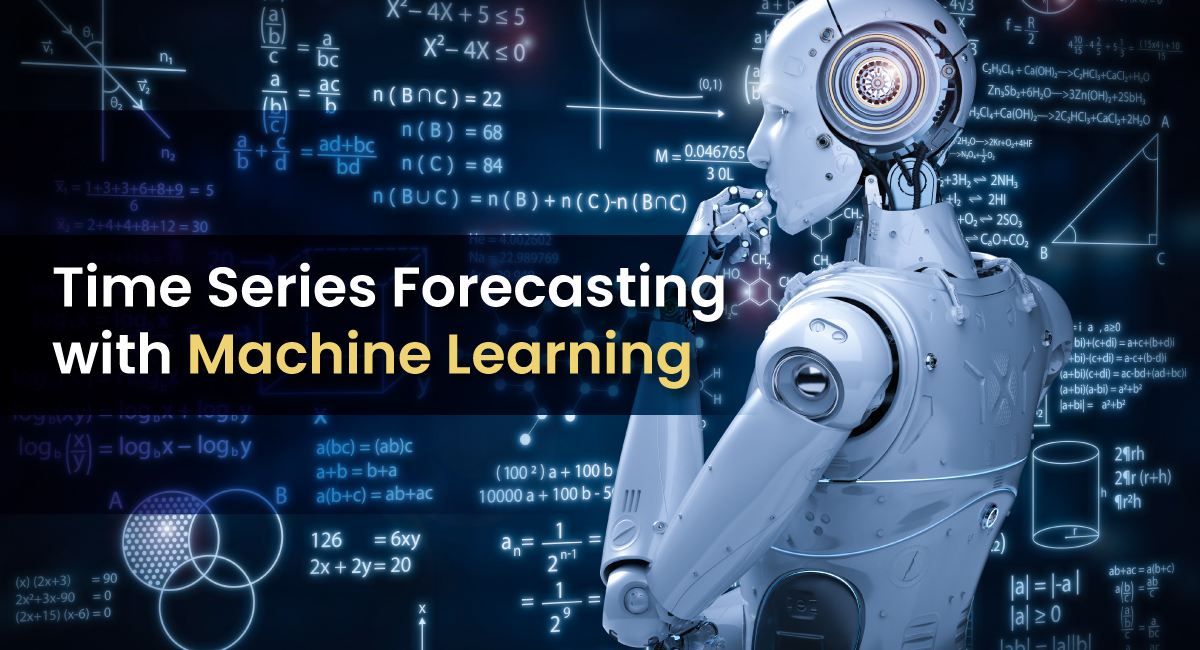

For the last 3 months of 2020, it is expected to make an estimation of the total trading volume on merchant_id and day basis.

Data of 7 member businesses from 2018 to 2021 are included.

**transaction_date:** Date of sales data<br>
**merchant_id:** Merchant id's (Unique number for each Merchant)<br>
**Total_Transaction:** Number of transactions<br>
**Total_Paid:** Payment amount

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import timedelta


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.expand_frame_repr', False)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_ = pd.read_csv('company_data.csv')

In [3]:
df = df_.copy()
df.head()

,Unnamed: 0,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,0,2018-01-01,535,349,25883.226
1,1,2018-01-01,42616,141,40918.860
2,2,2018-01-01,46774,410,306902.700
3,3,2018-01-01,86302,10,11.340
4,4,2018-01-01,124381,285,111383.766


In [4]:
def gen_info(df, box=True, column="Total_Transaction"):
    print(30*"#" + "Shape".center(30) + 30*"#")
    print(df.shape)
    print("\n"+ 30*"#" + "Head".center(30) + 30*"#")
    print(df.head())
    print("\n"+ 30*"#" + "Tail".center(30) + 30*"#")
    print(df.tail())
    print("\n"+ 30*"#" + "Types".center(30) + 30*"#")
    print(df.dtypes)
    print("\n"+ 30*"#" + "Missing Values".center(30) + 30*"#")
    print(df.isnull().sum())
    print("\n"+ 30*"#" + "Quantiles".center(30) + 30*"#")
    print(df.describe([0.25,0.50,0.75, 0.99]).T)
    print("\n"+ 30*"#" + "BOX PLOT".center(30) + 30*"#")
    if box == True:
        sns.boxplot(x=df[column])
        print(plt.show())

##############################            Shape             ##############################
(7667, 5)

##############################             Head             ##############################
   Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
0           0       2018-01-01          535                349   25883.226
1           1       2018-01-01        42616                141   40918.860
2           2       2018-01-01        46774                410  306902.700
3           3       2018-01-01        86302                 10      11.340
4           4       2018-01-01       124381                285  111383.766

##############################             Tail             ##############################
      Unnamed: 0 transaction_date  merchant_id  Total_Transaction  Total_Paid
7662        7662       2020-12-31        46774               3394 3174751.332
7663        7663       2020-12-31        57192                856  337696.020
7664        7664       2020-12-

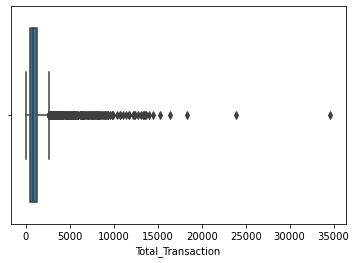

None


In [5]:
gen_info(df)

In [6]:
df["transaction_date"].min(), df["transaction_date"].max()

('2018-01-01', '2020-12-31')

In [7]:
df[["merchant_id"]].nunique()

merchant_id    7
dtype: int64

In [8]:
df.groupby(["merchant_id"]).agg({"Total_Transaction": ["sum", "mean", "median", "std"],
                                 "Total_Paid": ["sum", "mean", "median", "std"]})

Total_Transaction                                Total_Paid                                    
                          sum     mean   median      std            sum        mean      median         std
merchant_id                                                                                                
535                   1302725 1188.618 1029.500  498.633  156601530.234  142884.608  132031.134   60096.718
42616                 1126191 1027.547  667.000 1780.256  354583091.808  323524.719  187385.580  651079.014
46774                 1599559 1459.452 1313.500  844.590 1567200341.286 1429927.319 1238197.617  904056.310
57192                 1146440 1050.816 1073.000  215.101  317337137.586  290868.137  286297.506  108308.523
86302                  840951  767.291  160.000 1127.962    2870446.716    2619.021     404.010    4041.142
124381                1935357 1765.837  816.500 2245.710 1158692543.973 1057201.226  478098.891 1369114.005
129316                 440029  401.486  383.000  210.783    1555471.476    1419.226    1219.725     865.581

Let's change transaction_date type object to date

In [9]:
df["transaction_date"] = df["transaction_date"].apply(pd.to_datetime)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667 entries, 0 to 7666
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Unnamed: 0         7667 non-null   int64         
 1   transaction_date   7667 non-null   datetime64[ns]
 2   merchant_id        7667 non-null   int64         
 3   Total_Transaction  7667 non-null   int64         
 4   Total_Paid         7667 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 299.6 KB


In [11]:
df = df.drop("Unnamed: 0", axis = 1) # dropping Unnamed: 0 column

In [12]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


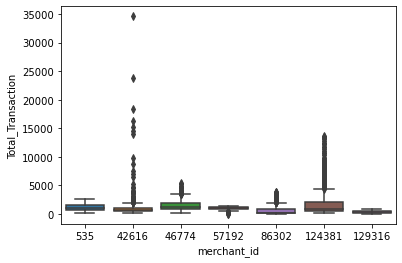

In [13]:
sns.boxplot(data = df, x = df["merchant_id"], y = df["Total_Transaction"])
plt.show(block=True)

In [14]:
df["year"] = df["transaction_date"].dt.year

In [15]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year
0,2018-01-01,535,349,25883.226,2018
1,2018-01-01,42616,141,40918.860,2018
2,2018-01-01,46774,410,306902.700,2018
3,2018-01-01,86302,10,11.340,2018
4,2018-01-01,124381,285,111383.766,2018


In [16]:
df.groupby(["merchant_id","year"]).agg({"Total_Transaction": ["sum", "mean", "median", "std"],
                                 "Total_Paid": ["sum", "mean", "median", "std"]})

Total_Transaction                               Total_Paid                                    
                               sum     mean   median      std           sum        mean      median         std
merchant_id year                                                                                               
535         2018            273402  749.047  767.000  171.773  31943064.888   87515.246   87240.942   25484.029
            2019            434672 1190.882 1153.000  412.588  54746755.146  149991.110  149166.000   42464.659
            2020            594651 1624.730 1654.500  403.452  69911710.200  191015.602  200155.500   54310.912
42616       2018            189402  518.910  407.000  874.398  49913811.522  136750.169  100245.672  275749.563
            2019            318784  873.381  623.000 2046.566  98642143.728  270252.449  171725.760  694014.583
            2020            618005 1688.538 1282.500 1961.611 206027136.558  562915.674  439773.174  787627.964
46774       2018            410259 1123.997 1053.000  588.112 355554884.430  974122.971  933321.510  533274.278
            2019            535471 1467.044 1332.000  787.137 533140870.320 1460659.919 1316705.904  808072.666
            2020            653829 1786.418 1597.500  978.465 678504586.536 1853837.668 1635806.655 1062197.842
57192       2018            324180  900.500  939.500  189.280  70468104.942  195744.736  194747.229   63097.730
            2019            379923 1040.885 1074.000  181.662 103705352.910  284124.255  291512.106   74021.044
            2020            442337 1208.571 1236.500  150.612 143163679.734  391157.595  396784.098   81215.832
86302       2018             38923  106.638  105.000   57.228     94155.552     257.960     252.612     150.988
            2019             51842  142.033  127.000   88.127    148887.216     407.910     347.490     274.058
            2020            750186 2049.689 2418.500 1153.007   2627403.948    7178.699    8650.332    4193.280
124381      2018            170631  467.482  439.000  182.649  89254049.058  244531.641  233451.540  111878.449
            2019            320002  876.718  798.000  422.981 192503961.622  527408.114  474531.732  251328.514
            2020           1444724 3947.333 3001.500 2769.427 876934533.294 2395995.993 1808323.289 1676171.051
129316      2018            112171  307.318  260.000  175.543    311161.050     852.496     734.850     495.937
            2019            144886  396.948  364.000  192.323    486296.550    1332.319    1229.400     696.576
            2020            182972  499.923  554.500  216.947    758013.876    2071.076    2337.300     873.909

In [17]:
df["merchant_id"] = df["merchant_id"].astype("category") # mercant Id should be category

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7667 entries, 0 to 7666
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   7667 non-null   datetime64[ns]
 1   merchant_id        7667 non-null   category      
 2   Total_Transaction  7667 non-null   int64         
 3   Total_Paid         7667 non-null   float64       
 4   year               7667 non-null   int64         
dtypes: category(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 247.6 KB


In [19]:
merchants = df["merchant_id"].unique()

In [20]:
len(merchants)

7

##############################
Merchant no:  535
##############################
      Total_Transaction   Total_Paid
year                                
2018             273402 31943064.888
2019             434672 54746755.146
2020             594651 69911710.200



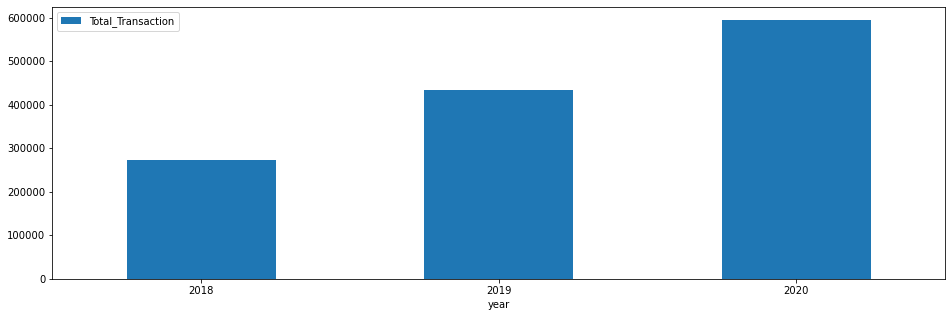

##############################
Merchant no:  42616
##############################
      Total_Transaction    Total_Paid
year                                 
2018             189402  49913811.522
2019             318784  98642143.728
2020             618005 206027136.558



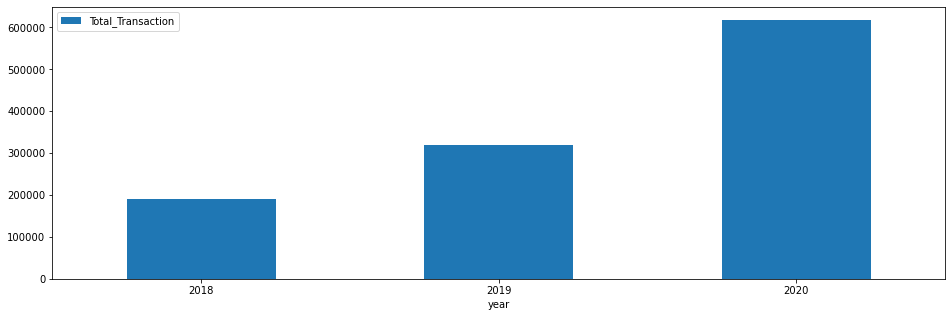

##############################
Merchant no:  46774
##############################
      Total_Transaction    Total_Paid
year                                 
2018             410259 355554884.430
2019             535471 533140870.320
2020             653829 678504586.536



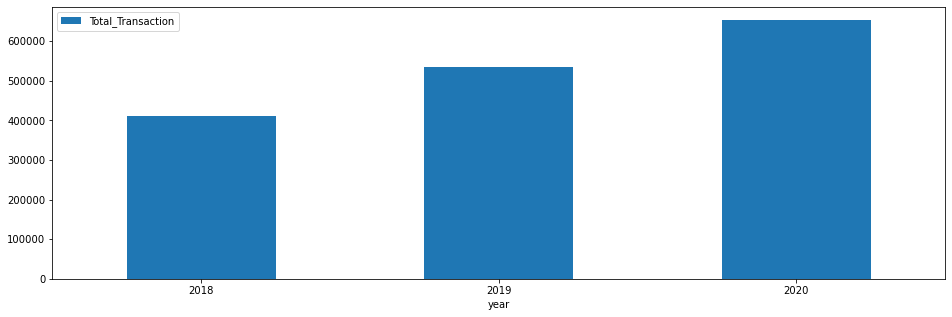

##############################
Merchant no:  86302
##############################
      Total_Transaction  Total_Paid
year                               
2018              38923   94155.552
2019              51842  148887.216
2020             750186 2627403.948



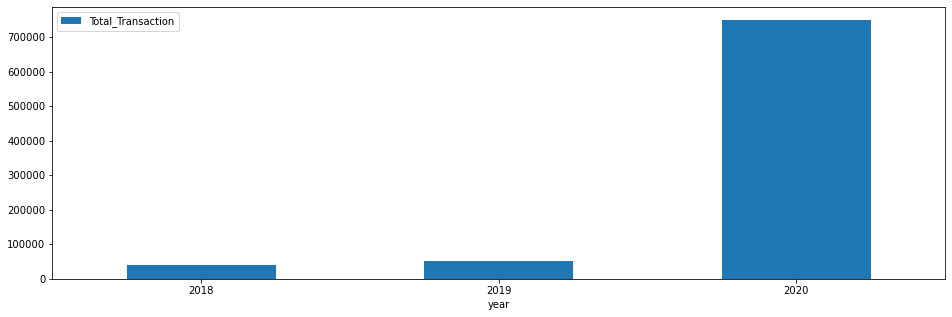

##############################
Merchant no:  124381
##############################
      Total_Transaction    Total_Paid
year                                 
2018             170631  89254049.058
2019             320002 192503961.622
2020            1444724 876934533.294



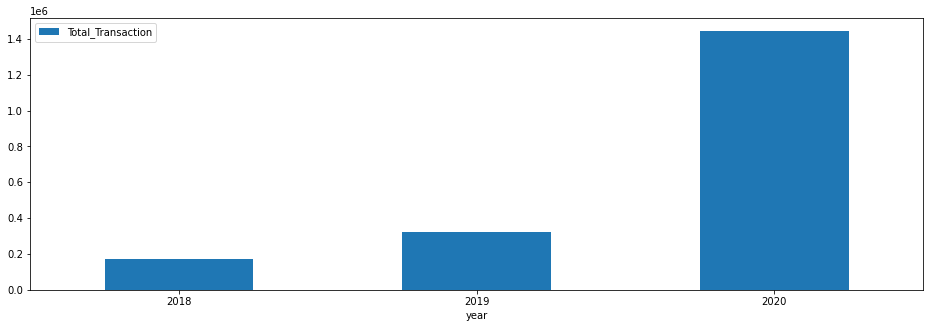

##############################
Merchant no:  129316
##############################
      Total_Transaction  Total_Paid
year                               
2018             112171  311161.050
2019             144886  486296.550
2020             182972  758013.876



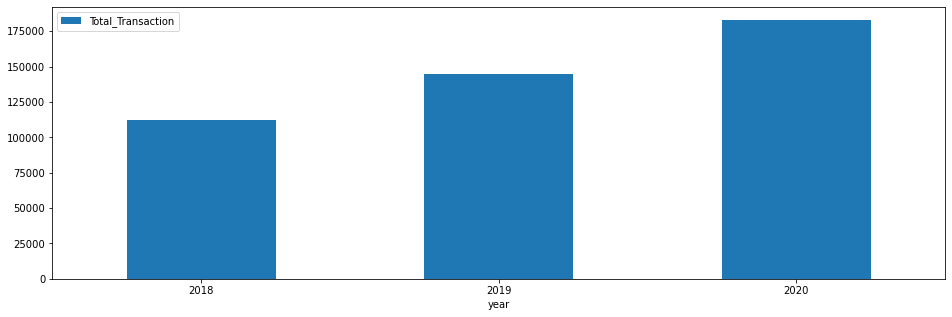

##############################
Merchant no:  57192
##############################
      Total_Transaction    Total_Paid
year                                 
2018             324180  70468104.942
2019             379923 103705352.910
2020             442337 143163679.734



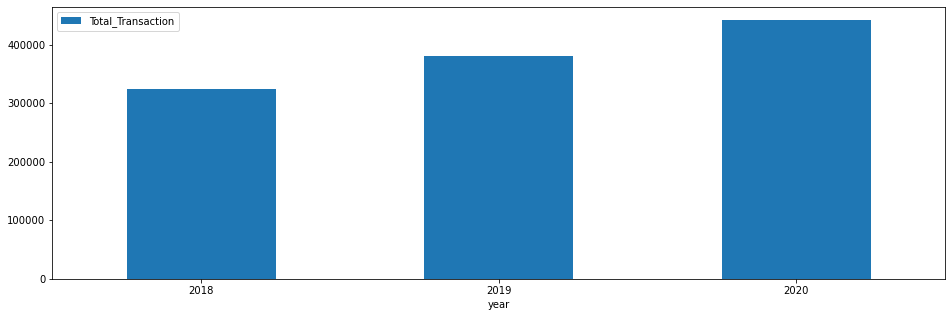

In [21]:
for merc in df["merchant_id"].unique():
    print(30*"#")
    print("Merchant no: ", merc)
    print(30*"#")
    print(df[df["merchant_id"] == merc].groupby("year").agg({'Total_Transaction':'sum',
                                                           'Total_Paid':'sum'}),end='\n\n')
    df[df["merchant_id"] == merc].groupby("year").agg({'Total_Transaction':'sum'}).plot(kind='bar', 
                                                                                       rot = 0,figsize=(16,5))
    plt.show()

## FEATURE ENGINEERING

Date features:

In [22]:
def create_date_features(df):
    df['month'] = df.transaction_date.dt.month
    df['day_of_month'] = df.transaction_date.dt.day
    df['day_of_year'] = df.transaction_date.dt.dayofyear
    df['week_of_year'] = df.transaction_date.dt.weekofyear
    df['day_of_week'] = df.transaction_date.dt.dayofweek
    df['year'] = df.transaction_date.dt.year
    df["is_wknd"] = df.transaction_date.dt.weekday // 4
    df['is_month_start'] = df.transaction_date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.transaction_date.dt.is_month_end.astype(int)
    return df

In [23]:
df = create_date_features(df)

In [24]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0
1,2018-01-01,42616,141,40918.860,2018,1,1,1,1,0,0,1,0
2,2018-01-01,46774,410,306902.700,2018,1,1,1,1,0,0,1,0
3,2018-01-01,86302,10,11.340,2018,1,1,1,1,0,0,1,0
4,2018-01-01,124381,285,111383.766,2018,1,1,1,1,0,0,1,0


random noise:

In [25]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

Lag/Shifted Features:

In [26]:
df.sort_values(by=['merchant_id', 'transaction_date'], axis=0).head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end
0,2018-01-01,535,349,25883.226,2018,1,1,1,1,0,0,1,0
6,2018-01-02,535,729,60263.928,2018,1,2,2,1,1,0,0,0
12,2018-01-03,535,657,51071.994,2018,1,3,3,1,2,0,0,0
18,2018-01-04,535,706,56995.110,2018,1,4,4,1,3,0,0,0
25,2018-01-05,535,648,66689.352,2018,1,5,5,1,4,1,0,0


In [27]:
df.sort_values(by=['merchant_id', 'transaction_date'], axis=0,  inplace=True)

In [28]:
pd.DataFrame({"Total_Transaction": df["Total_Paid"].values[0:10],
              "lag1": df["Total_Transaction"].shift(1).values[0:10],
              "lag2": df["Total_Transaction"].shift(2).values[0:10],
              "lag3": df["Total_Transaction"].shift(3).values[0:10],
              "lag4": df["Total_Transaction"].shift(4).values[0:10]})

,Total_Transaction,lag1,lag2,lag3,lag4
0,25883.226,NaN,NaN,NaN,NaN
1,60263.928,349.000,NaN,NaN,NaN
2,51071.994,729.000,349.000,NaN,NaN
3,56995.110,657.000,729.000,349.000,NaN
4,66689.352,706.000,657.000,729.000,349.000
5,55923.588,648.000,706.000,657.000,729.000
6,65682.396,581.000,648.000,706.000,657.000
7,65227.608,613.000,581.000,648.000,706.000
8,78227.118,654.000,613.000,581.000,648.000
9,76767.552,782.000,654.000,613.000,581.000


In [29]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['Total_Transaction' 
                  + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [30]:
df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546])

In [31]:
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,Total_Transaction91,Total_Transaction98,Total_Transaction105,Total_Transaction112,Total_Transaction119,Total_Transaction126,Total_Transaction182,Total_Transaction364,Total_Transaction546
7638,2020-12-27,129316,620,2686.950,2020,12,27,362,52,6,1,0,0,539.173,518.960,443.251,527.567,494.183,469.442,282.886,496.165,304.155
7645,2020-12-28,129316,640,2790.900,2020,12,28,363,53,0,0,0,0,540.576,606.992,532.265,651.394,539.143,558.778,415.227,562.518,406.537
7652,2020-12-29,129316,703,2950.650,2020,12,29,364,53,1,0,0,0,671.267,649.504,632.679,646.898,615.439,509.573,420.712,561.009,469.890
7659,2020-12-30,129316,642,2890.350,2020,12,30,365,53,2,0,0,0,696.386,713.891,595.083,601.943,561.370,589.160,407.417,397.931,509.154
7666,2020-12-31,129316,485,2101.050,2020,12,31,366,53,3,0,0,1,682.074,597.945,626.281,613.318,532.056,589.208,479.629,555.618,558.126


Rolling Mean Features:

In [32]:
pd.DataFrame({"Total_Transaction": df["Total_Paid"].values[0:10],
              "roll2": df["Total_Transaction"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["Total_Transaction"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["Total_Transaction"].shift(1).rolling(window=5).mean().values[0:10]})

,Total_Transaction,roll2,roll3,roll5
0,25883.226,NaN,NaN,NaN
1,60263.928,NaN,NaN,NaN
2,51071.994,539.000,NaN,NaN
3,56995.110,693.000,578.333,NaN
4,66689.352,681.500,697.333,NaN
5,55923.588,677.000,670.333,617.800
6,65682.396,614.500,645.000,664.200
7,65227.608,597.000,614.000,641.000
8,78227.118,633.500,616.000,640.400
9,76767.552,718.000,683.000,655.600


In [33]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['Total_Transaction_roll_mean_' 
                  + str(window)] = dataframe.groupby(["merchant_id"])['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

In [34]:
df = roll_mean_features(df, [91,181,365,546])

In [35]:
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,Total_Transaction91,Total_Transaction98,Total_Transaction105,Total_Transaction112,Total_Transaction119,Total_Transaction126,Total_Transaction182,Total_Transaction364,Total_Transaction546,Total_Transaction_roll_mean_91,Total_Transaction_roll_mean_181,Total_Transaction_roll_mean_365,Total_Transaction_roll_mean_546
7638,2020-12-27,129316,620,2686.950,2020,12,27,362,52,6,1,0,0,539.173,518.960,443.251,527.567,494.183,469.442,282.886,496.165,304.155,605.921,577.406,424.791,480.596
7645,2020-12-28,129316,640,2790.900,2020,12,28,363,53,0,0,0,0,540.576,606.992,532.265,651.394,539.143,558.778,415.227,562.518,406.537,608.614,580.886,420.648,482.966
7652,2020-12-29,129316,703,2950.650,2020,12,29,364,53,1,0,0,0,671.267,649.504,632.679,646.898,615.439,509.573,420.712,561.009,469.890,610.094,581.915,423.478,478.241
7659,2020-12-30,129316,642,2890.350,2020,12,30,365,53,2,0,0,0,696.386,713.891,595.083,601.943,561.370,589.160,407.417,397.931,509.154,609.568,581.425,425.582,479.567
7666,2020-12-31,129316,485,2101.050,2020,12,31,366,53,3,0,0,1,682.074,597.945,626.281,613.318,532.056,589.208,479.629,555.618,558.126,609.070,583.285,426.051,480.848


Exponentially Weighted Mean Features:

In [36]:
pd.DataFrame({"Total_Transaction": df["Total_Paid"].values[0:10],
              "roll2": df["Total_Transaction"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["Total_Transaction"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["Total_Transaction"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["Total_Transaction"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["Total_Transaction"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,Total_Transaction,roll2,ewm099,ewm095,ewm07,ewm02
0,25883.226,NaN,NaN,NaN,NaN,NaN
1,60263.928,NaN,349.000,349.000,349.000,349.000
2,51071.994,539.000,725.238,710.905,641.308,549.000
3,56995.110,693.000,657.682,659.689,652.597,588.852
4,66689.352,681.500,705.517,703.685,690.284,622.917
5,55923.588,677.000,648.575,650.784,660.613,629.042
6,65682.396,614.500,581.676,584.489,604.843,618.789
7,65227.608,597.000,612.687,611.574,610.554,617.679
8,78227.118,633.500,653.587,651.879,640.968,624.057
9,76767.552,718.000,780.716,775.494,739.692,649.840


In [37]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['Total_Transaction_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).
                                                                         ewm(alpha=alpha).mean())
    return dataframe

In [38]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546]

df = ewm_features(df, alphas, lags)

In [39]:
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,year,month,day_of_month,day_of_year,week_of_year,day_of_week,is_wknd,is_month_start,is_month_end,Total_Transaction91,Total_Transaction98,Total_Transaction105,Total_Transaction112,Total_Transaction119,Total_Transaction126,Total_Transaction182,Total_Transaction364,Total_Transaction546,Total_Transaction_roll_mean_91,Total_Transaction_roll_mean_181,Total_Transaction_roll_mean_365,Total_Transaction_roll_mean_546,Total_Transaction_ewm_alpha_095_lag_91,Total_Transaction_ewm_alpha_095_lag_98,Total_Transaction_ewm_alpha_095_lag_105,Total_Transaction_ewm_alpha_095_lag_112,Total_Transaction_ewm_alpha_095_lag_180,Total_Transaction_ewm_alpha_095_lag_270,Total_Transaction_ewm_alpha_095_lag_365,Total_Transaction_ewm_alpha_095_lag_546,Total_Transaction_ewm_alpha_09_lag_91,Total_Transaction_ewm_alpha_09_lag_98,Total_Transaction_ewm_alpha_09_lag_105,Total_Transaction_ewm_alpha_09_lag_112,Total_Transaction_ewm_alpha_09_lag_180,Total_Transaction_ewm_alpha_09_lag_270,Total_Transaction_ewm_alpha_09_lag_365,Total_Transaction_ewm_alpha_09_lag_546,Total_Transaction_ewm_alpha_08_lag_91,Total_Transaction_ewm_alpha_08_lag_98,Total_Transaction_ewm_alpha_08_lag_105,Total_Transaction_ewm_alpha_08_lag_112,Total_Transaction_ewm_alpha_08_lag_180,Total_Transaction_ewm_alpha_08_lag_270,Total_Transaction_ewm_alpha_08_lag_365,Total_Transaction_ewm_alpha_08_lag_546,Total_Transaction_ewm_alpha_07_lag_91,Total_Transaction_ewm_alpha_07_lag_98,Total_Transaction_ewm_alpha_07_lag_105,Total_Transaction_ewm_alpha_07_lag_112,Total_Transaction_ewm_alpha_07_lag_180,Total_Transaction_ewm_alpha_07_lag_270,Total_Transaction_ewm_alpha_07_lag_365,Total_Transaction_ewm_alpha_07_lag_546,Total_Transaction_ewm_alpha_05_lag_91,Total_Transaction_ewm_alpha_05_lag_98,Total_Transaction_ewm_alpha_05_lag_105,Total_Transaction_ewm_alpha_05_lag_112,Total_Transaction_ewm_alpha_05_lag_180,Total_Transaction_ewm_alpha_05_lag_270,Total_Transaction_ewm_alpha_05_lag_365,Total_Transaction_ewm_alpha_05_lag_546
7638,2020-12-27,129316,620,2686.950,2020,12,27,362,52,6,1,0,0,539.173,518.960,443.251,527.567,494.183,469.442,282.886,496.165,304.155,605.921,577.406,424.791,480.596,539.367,519.184,450.984,526.996,418.567,229.254,546.364,311.299,541.148,519.753,459.483,525.370,417.491,227.622,551.835,318.188,545.901,522.116,477.709,523.193,413.560,224.773,562.949,330.765,552.231,526.177,497.054,522.405,407.585,222.704,574.034,341.948,569.273,538.972,536.406,524.980,391.461,223.764,594.838,361.763
7645,2020-12-28,129316,640,2790.900,2020,12,28,363,53,0,0,0,0,540.576,606.992,532.265,651.394,539.143,558.778,415.227,562.518,406.537,608.614,580.886,420.648,482.966,541.868,601.659,526.049,644.800,408.528,185.313,498.518,403.165,541.915,597.375,522.948,638.437,408.949,187.462,501.583,399.019,542.780,589.223,519.542,625.439,409.112,191.355,509.390,392.553,545.069,582.053,520.116,612.421,407.875,194.911,519.410,388.184,555.637,572.486,533.203,587.990,399.730,203.382,545.419,384.882
7652,2020-12-29,129316,703,2950.650,2020,12,29,364,53,1,0,0,0,671.267,649.504,632.679,646.898,615.439,509.573,420.712,561.009,469.890,610.094,581.915,423.478,478.241,665.493,646.633,625.752,645.940,474.526,158.416,559.776,466.658,658.991,643.838,620.195,645.244,471.095,160.046,556.858,462.902,646.156,637.045,608.708,641.888,464.222,163.871,552.278,454.511,633.921,628.916,597.735,635.926,456.963,168.373,549.923,445.455,613.818,610.743,582.102,616.995,438.865,180.191,554.210,427.441
7659,2020-12-30,129316,642,2890.350,2020,12,30,365,53,2,0,0,0,696.386,713.891,595.083,601.943,561.370,589.160,407.417,397.931,509.154,609.568,581.425,425.582,479.567,695.425,712.532,592.738,602.297,444.576,148.521,559.989,507.833,693.199,708.784,593.919,604.524,445.809,149.205,559.686,505.290,686.831,700.209,594.542,608.378,447.244,151.174,558.456,498.902,678.076,689.875,593.020,610.778,447.189,154.112,556.977,490.637,655.409,663.371,586.551,608.497,440.933,164.096,557.105,468.720
7666,2020-12-31,129316,485,2

In [40]:
df["paid_per_transaction"] = df["Total_Paid"]/df["Total_Transaction"]

In [41]:
df.shape

(7667, 67)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7667 entries, 0 to 7666
Data columns (total 67 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   transaction_date                         7667 non-null   datetime64[ns]
 1   merchant_id                              7667 non-null   category      
 2   Total_Transaction                        7667 non-null   int64         
 3   Total_Paid                               7667 non-null   float64       
 4   year                                     7667 non-null   int64         
 5   month                                    7667 non-null   int64         
 6   day_of_month                             7667 non-null   int64         
 7   day_of_year                              7667 non-null   int64         
 8   week_of_year                             7667 non-null   int64         
 9   day_of_week                              

##### One-Hot Encoding

In [43]:
df = pd.get_dummies(df, columns=['merchant_id', 'year', 'day_of_week', 'month'])

In [44]:
df.shape

(7667, 92)

Converting sales to log(1+sales):

In [45]:
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

##### Custom Cost Function

In [46]:
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [47]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

##### Time-Based Validation Sets

In [48]:
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

In [49]:
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

In [50]:
cols = [col for col in train.columns if col not in ["Total_Transaction","transaction_date"]]
Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

In [51]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 90), (644,), (644, 90))

## MODEL

##### Time Series Model with LightGBM

In [52]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [53]:
lgb_params = {'num_leaves': 20,
              'learning_rate': 0.02,
              'feature_fraction': 0.9,
              'max_depth': 15,
              'verbose': 0,
              'num_boost_round': 50000,
              'early_stopping_rounds': 500,
              'nthread': -1}

In [54]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=5000
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[324]	training's l2: 0.00571718	training's SMAPE: 5.25565	valid_1's l2: 0.0131298	valid_1's SMAPE: 8.28384


In [55]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [56]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

8.283834942698059

In [57]:
def plot_lgb_importances(model, plot=True, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:10])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

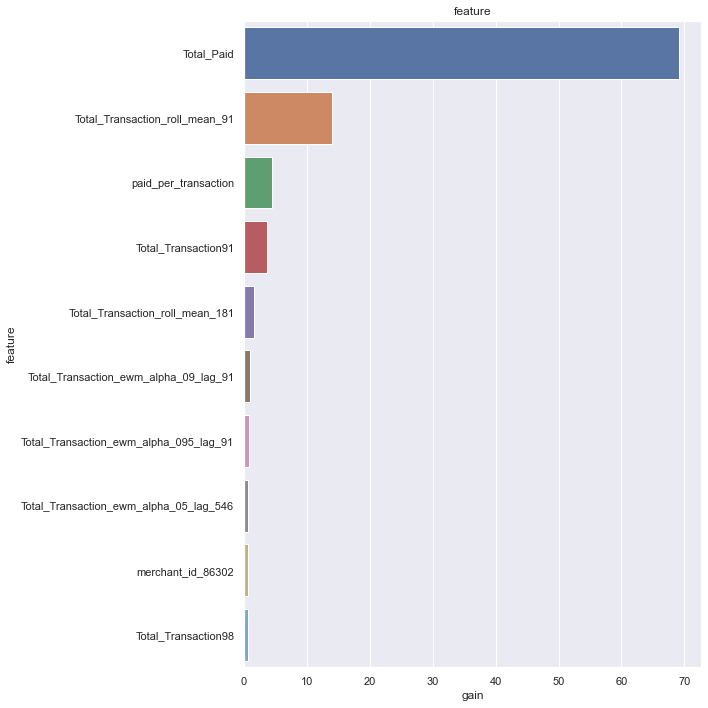

,feature,split,gain
0,Total_Paid,2393,69.217
16,Total_Transaction_roll_mean_91,303,14.015
60,paid_per_transaction,1642,4.401
7,Total_Transaction91,126,3.708
17,Total_Transaction_roll_mean_181,192,1.598
28,Total_Transaction_ewm_alpha_09_lag_91,38,0.926
20,Total_Transaction_ewm_alpha_095_lag_91,56,0.899
59,Total_Transaction_ewm_alpha_05_lag_546,66,0.698
65,merchant_id_86302,92,0.657
8,Total_Transaction98,26,0.602


In [58]:
plot_lgb_importances(model, num=200)

In [59]:
np.expm1(y_pred_val) # predicted Total_Paid vaules

array([ 2109.55080311,  1933.74075672,  1869.38292969,  1857.99586614,
        2070.51346636,  2055.64138924,  2068.37671117,  2032.02467012,
        1930.90660034,  1827.83621625,  1848.60826832,  2084.42507932,
        2089.4058238 ,  2075.46098491,  2072.0202557 ,  1934.45822546,
        1789.65935714,  1830.30385153,  2061.8145084 ,  2049.21093339,
        2038.55170298,  2034.08287294,  1924.85153004,  1785.72636586,
        1777.12776579,  2029.25301517,  2016.22377661,  1971.62999386,
        1986.30593174,  1486.77091216,  1558.5959449 ,  1783.99566265,
        2055.4069161 ,  2024.67635653,  2037.48294755,  2030.91091297,
        1765.40041132,  1727.23420455,  1754.8107347 ,  1997.01873779,
        2001.79072452,  2000.87031943,  1997.93048535,  1856.48153705,
        1770.00670734,  1793.81365564,  2045.24649734,  1997.93048535,
        2003.60761058,  1997.93048535,  1838.02817625,  1618.3883485 ,
        1717.5483349 ,  1990.50740559,  1937.41019081,  1936.30754809,
      

## Final Model

In [60]:
cols = [col for col in df.columns if col not in ["Total_Transaction","transaction_date"]]
Y_train = df['Total_Transaction']
X_train = df[cols] # with all data

In [61]:
Y_train.shape,X_train.shape

((7667,), (7667, 90))

In [62]:
lgb_params = {'num_leaves': 20,
              'learning_rate': 0.02,
              'feature_fraction': 0.9,
              'max_depth': 15,
              'verbose': 0,
              'num_boost_round': model.best_iteration,
              'nthread': -1}

In [63]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

In [64]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004809 seconds.
You can set `force_col_wise=true` to remove the overhead.


Hope it will be useful :)

[Linkedin](https://www.linkedin.com/in/demir-zumrut/)